In [6]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, ConvLSTM2D, Conv3D, BatchNormalization, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import data_preprocessing as dpp
from keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
tf.random.set_seed(1)
np.random.seed(1)

# Data Preprocessing

In [2]:
img_folder = 'data/data1-(8.7μm)'

img_tensors = dpp.preprocess_images(img_folder,target_size=(50,50), end_i=40)

print(img_tensors)

SyntaxError: positional argument follows keyword argument (4024106138.py, line 3)

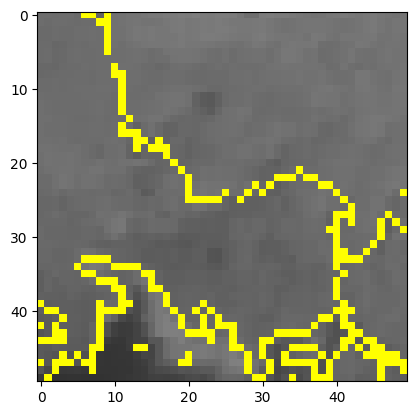

In [3]:
plt.imshow(img_tensors[0])

In [7]:
data_2410_300 = np.load("data/data_/data_2410_300.npy")
data_2410_715 = np.load("data/data_/data_2410_715.npy")
print(data_2410_300.shape, data_2410_715.shape )
data_2410 = np.concatenate((data_2410_300, data_2410_715), axis=0)
print(data_2410.shape)
inputs, outputs = dpp.split_images(data_2410)
print(inputs.shape, outputs.shape)
"""inputs = np.load("data/data_/data_2410_input.npy")
outputs = np.load("data/data_/data_2410_output.npy")"""

(300, 40, 40, 4) (415, 40, 40, 4)
(715, 40, 40, 4)
(47, 14, 40, 40, 4) (47, 1, 40, 40, 4)


'inputs = np.load("data/data_/data_2410_input.npy")\noutputs = np.load("data/data_/data_2410_output.npy")'

In [11]:
#기존 데이터 크기인 47,15,850,850,4를 하면 2,037,450,000개의 공간이 생김 (20억개???)
#기존 연구 28,30,40,1 -> 33,600개
#rgba 4개의 채널까지 하더라도 134,400개임
#100,15,40,40,4 -> 최대 천만개
inputs.shape, outputs.shape
np.save("data/data_/data_2410_input",inputs)
np.save("data/data_/data_2410_output",outputs)

In [4]:
data_2410 = np.load("data/data_/data_2410.npy")

In [15]:
data_2410.shape

(715, 850, 850, 4)

In [20]:
def resize_images(dataset, target_size):
    resized_dataset = tf.image.resize(dataset, target_size, method='bilinear')
    return resized_dataset
resized_images = resize_images(data_2410[300:], (40,40))

In [21]:
np.save("data/data_/data_2410_715", resized_images)

# Modeling

In [9]:
# 자 모델 구축 들갑니다~
model = Sequential()
model.add(ConvLSTM2D(filters=20, 
                     kernel_size=(3,3), 
                     input_shape=(None,40,40,4), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=20, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=20, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=20, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=False))
model.add(BatchNormalization())
model.add(Lambda(lambda x: tf.expand_dims(x, axis=1)))
model.add(Conv3D(filters=4, 
                 kernel_size=(3,3,3), 
                 activation="sigmoid",
                 padding="same"))
model.compile(loss='binary_crossentropy',optimizer='adadelta', metrics = ['accuracy'])
callbacks_val_acc = [EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True),
                     ModelCheckpoint("ClimateAI.keras", monitor='val_accuracy', save_best_only=True)]
callbacks_val_loss = [EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True),
                      ModelCheckpoint("ClimateAI.keras", monitor='val_loss', save_best_only=True)]
callbacks = [callbacks_val_acc, callbacks_val_loss]

model.summary()

/Volumes/looparam/#1 Coding/#10 Python/AcademicFestival/AF/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, None, 40, 40,   │        17,360 │
│                                 │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 40, 40,   │            80 │
│ (BatchNormalization)            │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, None, 40, 40,   │        28,880 │
│                                 │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 40, 40,   │            80 │
│ (BatchNormalization)            │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, None, 40, 40,   │        28,880 │
│                                 │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 40, 40,   │            80 │
│ (BatchNormalization)            │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 40, 40, 20)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 40, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1, 40, 40, 20)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 1, 40, 40, 4)   │         2,164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,484 (415.95 KB)

 Trainable params: 106,324 (415.33 KB)

 Non-trainable params: 160 (640.00 B)

# Train

In [10]:
model.fit(inputs, outputs, epochs=1, batch_size=2, validation_split=0.1, callbacks=callbacks)

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.3296 - loss: 0.7764 - val_accuracy: 0.2851 - val_loss: 0.6910
